In [1]:
from snowflake.snowpark import (
    Session,
    functions as F, 
    types as T
)
import os
import json
import pandas as pd
import datetime
import calendar
from pandas.tseries.offsets import MonthEnd

In [2]:
snowflake_connections = ["AIRFLOW_CONN_SNOWFLAKE_DEFAULT"]
snowflake_accounts = ["FY02423-SNOWSERVICES_PREVIEW", "FY02423-GP21411"]

In [3]:
connection_params = json.loads(os.environ[snowflake_connections[0]])
connection_params['user'] = connection_params.pop('login')
connection_params['account'] = snowflake_accounts[1] #connection_params['extra'].pop('account')
# connection_params['role'] = "ACCOUNTADMIN"
connection_params['database'] = "sandbox" #connection_params['extra'].pop('database')
connection_params['schema'] = "michaelgregory" #connection_params['schema']
# connection_params['region'] = connection_params['extra'].pop('region')
connection_params['application'] = connection_params['extra'].pop('application')
snowpark_session = Session.builder.configs(connection_params).create()

In [4]:
report_year =  2023
report_month = 11
month_end_day = calendar.monthrange(report_year, report_month)[1]
end_date = min(datetime.date(report_year, report_month, month_end_day), 
               datetime.date.today())
end_date
account_start_cutoff_date = datetime.date(2022, 11, 15)

In [5]:
# databases = snowpark_session.sql('SHOW DATABASES;').collect()
# databases = [database.as_dict().get('name') for database in databases]
# database=databases[0]
# snowpark_session.sql(f'show views in {database}.INFORMATION_SCHEMA').collect()

In [6]:
storage_history_df = snowpark_session.table('SNOWFLAKE.ACCOUNT_USAGE.STORAGE_USAGE').rename(F.col('USAGE_DATE'), 'DATE')
storage_history_df.sort('DATE', ascending=True).show()

---------------------------------------------------------------------------------
|"DATE"      |"STORAGE_BYTES"       |"STAGE_BYTES"       |"FAILSAFE_BYTES"      |
---------------------------------------------------------------------------------
|2022-11-01  |1318412114663.000000  |30265748728.000000  |2243022119792.000000  |
|2022-11-02  |1269974705905.000000  |30467999094.000000  |2396298572451.000000  |
|2022-11-03  |848024359338.000000   |30665361069.000000  |2665574070098.000000  |
|2022-11-04  |744313862333.000000   |30903116079.000000  |2559117254069.000000  |
|2022-11-05  |743682015647.000000   |31058591601.000000  |2403607814104.000000  |
|2022-11-06  |743567264855.000000   |31089002479.000000  |2166224446474.000000  |
|2022-11-07  |746666291169.000000   |31089013625.000000  |1957733760708.000000  |
|2022-11-08  |757508141973.000000   |31136711015.000000  |1744951427913.000000  |
|2022-11-09  |747493999474.000000   |31226042016.000000  |1439328172229.000000  |
|2022-11-10  |75

In [7]:
compute_history_df = snowpark_session.table('SNOWFLAKE.ACCOUNT_USAGE.METERING_DAILY_HISTORY').rename(F.col('USAGE_DATE'), 'DATE')
compute_history_df.sort('DATE', ascending=True).show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SERVICE_TYPE"   |"DATE"      |"CREDITS_USED_COMPUTE"  |"CREDITS_USED_CLOUD_SERVICES"  |"CREDITS_USED"  |"CREDITS_ADJUSTMENT_CLOUD_SERVICES"  |"CREDITS_BILLED"  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------
|AUTO_CLUSTERING  |2020-11-26  |0.000053698             |0E-9                           |0.000053698     |0E-10                                |0.0000536980      |
|AUTO_CLUSTERING  |2020-12-08  |0.000082657             |0E-9                           |0.000082657     |0E-10                                |0.0000826570      |
|AUTO_CLUSTERING  |2020-12-11  |0.222525375             |0E-9                           |0.222525375     |0E-10                                |0.2225253750      |
|AUTO_CLUSTERING

In [8]:
compute_history_df.select('SERVICE_TYPE').distinct().show()

----------------------
|"SERVICE_TYPE"      |
----------------------
|AUTO_CLUSTERING     |
|WAREHOUSE_METERING  |
----------------------



In [9]:
start_date = max(min(compute_history_df.select(F.min('DATE').alias('DATE')).collect()[0]["DATE"],
                     storage_history_df.select(F.min('DATE').alias('DATE')).collect()[0]["DATE"]),
                account_start_cutoff_date)

date_df = pd.DataFrame(pd.date_range(start=start_date, end=end_date), columns=['DATE'])
date_df.DATE = date_df.DATE.dt.date # tz_localize('UTC').to_list()
date_df = snowpark_session.create_dataframe(date_df)

In [10]:
sum_cols = [x for x in storage_history_df.columns if x != storage_history_df.columns[0]]

storage_used = storage_history_df.with_column('STORAGE', F.cast(sum([F.col(c) for c in sum_cols]), T.FloatType()))\
                                 .select(['DATE', 'STORAGE'])\
                                 .join(date_df, on='DATE', how='right')

In [11]:
compute_used = compute_history_df.group_by('DATE').sum(F.col('CREDITS_USED'))\
                                 .join(date_df, on='DATE', how='right')\
                                 .rename(F.col("SUM(CREDITS_USED)"), "COMPUTE")\
                                 .select([F.col('DATE'), F.cast(F.col('COMPUTE'), T.FloatType()).alias('COMPUTE')])

In [12]:
usage_df = compute_used.join(storage_used, on='DATE').sort('DATE').fillna(0, subset=['COMPUTE', 'STORAGE']).to_pandas().set_index('DATE')

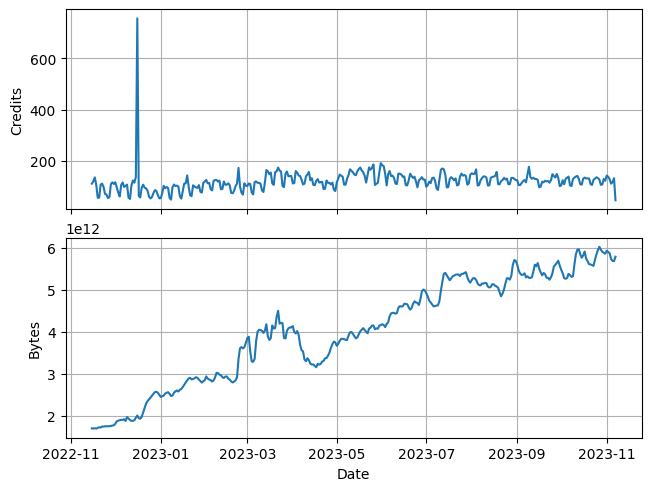

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, sharex='all', layout='constrained')
axs[0].plot(usage_df['COMPUTE'])
# axs[0].set_xlabel('Date')
axs[0].set_ylabel('Credits')
axs[0].grid(True)

axs[1].plot(usage_df['STORAGE'])
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Bytes')
axs[1].grid(True)

plt.show()

In [14]:
usage_df['STORAGE'].sort_values()

DATE
2022-11-18    1.699329e+12
2022-11-16    1.701101e+12
2022-11-15    1.705230e+12
2022-11-17    1.710054e+12
2022-11-19    1.718348e+12
                  ...     
2023-10-26    5.948175e+12
2023-10-12    5.957607e+12
2023-10-28    5.959866e+12
2023-10-13    5.966874e+12
2023-10-27    6.027011e+12
Name: STORAGE, Length: 358, dtype: float64

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
scalar = StandardScaler() 
# usage_df[['COMPUTE', 'STORAGE']] = scalar.fit_transform(usage_df[['COMPUTE', 'STORAGE']])

In [17]:
# usage_df[['COMPUTE', 'STORAGE']]

In [18]:
connection_params

{'conn_type': 'snowflake',
 'password': 'tyur5tgb^YHN',
 'schema': 'michaelgregory',
 'extra': {'account': 'FY02423-SNOWSERVICES_PREVIEW',
  'warehouse': 'HUMANS',
  'database': 'demo',
  'region': '',
  'role': 'MICHAELGREGORY',
  'authenticator': 'snowflake'},
 'user': 'MICHAELGREGORY',
 'account': 'FY02423-GP21411',
 'database': 'sandbox',
 'application': 'AIRFLOW'}

In [19]:
currency_usage = snowpark_session.table('SNOWFLAKE.ORGANIZATION_USAGE.USAGE_IN_CURRENCY_DAILY')

In [20]:
#currency_usage.where(F.col('USAGE_DATE') == '2023-11-06').show()
currency_usage.where(F.col('USAGE_TYPE') == 'overage-storage').sort('USAGE_DATE', ascending=False).show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORGANIZATION_NAME"  |"CONTRACT_NUMBER"  |"ACCOUNT_NAME"  |"ACCOUNT_LOCATOR"  |"REGION"       |"SERVICE_LEVEL"  |"USAGE_DATE"  |"USAGE_TYPE"     |"CURRENCY"  |"USAGE"   |"USAGE_IN_CURRENCY"  |"BALANCE_SOURCE"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|FY02423              |19072              |GP21411         |GP21411            |AWS_US_EAST_1  |Standard         |2021-12-30    |overage-storage  |USD         |0.007724  |0.308969             |Overage           |
|FY02423              |19072              |GP21411         |GP21411            |AWS_US_EAST_1  |Standard         |2021-12-29    |overage-storage  |U

In [21]:
#snowpark_session.close()